In [ ]:
#--------------------------- PART 1 : The sets ---------------------------------

In [ ]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_datasets as tfds
import tensorflow as tf
import keras
from keras import metrics

#!pip install keras-utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, SimpleRNN, LSTM, Activation
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

from gensim.parsing.preprocessing import remove_stopwords

tfds.disable_progress_bar()

In [ ]:
# Import dataset
data = pd.read_csv('/content/Project Dataset.csv')
data

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [ ]:
# Show proportion of target
data['target'].value_counts(normalize=True) * 100

0    81.407212
1    18.592788
Name: target, dtype: float64

In [ ]:
#------------------------------ PART 2 : Cleaning -----------------------------

In [ ]:
# Create remove functions to clean the sets

## Function to remove URL
import re 
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

example = data.iloc[873,3]  # This is an example of a tweet containing chinese 
                             # symbols, emojis, url, and digits.

print("Example 1")
print("Before :",example)
print("After removing url -->", remove_URL(example))

## Function to remove emojis and chinese symbols
example = remove_URL(example)
def remove_emoji(text):
  regrex_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
  return regrex_pattern.sub(r'',text)
    
print("After removing emojis -->", remove_emoji(example))
example = remove_emoji(example)

# Function to remove digits
example = re.sub('\d+', '', example)
print("After removing digits -->", example)

# Function to remove stopwords
example2 = data.iloc[0,3]
print("\n\nExample 2")
print("Before :", example2)
example2 = remove_stopwords(example2)
print("After removing stopwords -->", example2)

#Function to remove punctuation
print("After removing punctuation -->", re.sub(r'[^\w\s]','',example2))

Example 1
Before : 200105 Golden Disc Awards 📸 carol_e555558 #BTSxGDA #JHOPE #RM 💐 https://t.co/Yj8VwEZu9D
After removing url --> 200105 Golden Disc Awards 📸 carol_e555558 #BTSxGDA #JHOPE #RM 💐 
After removing emojis --> 200105 Golden Disc Awards  carol_e555558 #BTSxGDA #JHOPE #RM  
After removing digits -->  Golden Disc Awards  carol_e #BTSxGDA #JHOPE #RM  


Example 2
Before : Communal violence in Bhainsa, Telangana. "Stones were pelted on Muslims' houses and some houses and vehicles were set ablaze…
After removing stopwords --> Communal violence Bhainsa, Telangana. "Stones pelted Muslims' houses houses vehicles set ablaze…
After removing punctuation --> Communal violence Bhainsa Telangana Stones pelted Muslims houses houses vehicles set ablaze


In [ ]:
# Clean the dataset
data['text'] = data['text'].apply(lambda x : remove_URL(x))
data['text'] = data['text'].apply(lambda x: remove_emoji(x))
data['text'] = data['text'].str.replace('\d+', '')
data['text'] = data['text'].apply(lambda x : remove_stopwords(x))
data['text'] = data['text'].str.replace('[^\w\s]', '')

# Drop useless columns
data = data.drop(columns = ["id", "keyword", "location"])

In [ ]:
#---------------------------- PART 3 : Split in 2 sets ------------------------

In [ ]:
# Create train/test with a split of 80/20
copy = data.copy() #This allows tr
train = copy[:9096]
test = copy[9096:]

In [ ]:
train.head()

,text,target
0,Communal violence Bhainsa Telangana Stones pel...,1
1,Telangana Section imposed Bhainsa January cla...,1
2,Arsonist sets cars ablaze dealership,1
3,Arsonist sets cars ablaze dealership,1
4,Lord Jesus love brings freedom pardon Fill Hol...,0


In [ ]:
test.reset_index(drop=True, inplace=True)
test.head()

,text,target
0,Heard seismic activity going on Brings memorie...,0
1,Blimey His departure seismic,0
2,Well wear tan suit Like meant seismic scandal ...,0
3,Taal volcano news live Hundreds thousands urg...,1
4,The Philippine Seismic Network recorded total ...,0


In [ ]:
# Show proportion of target in train
train['target'].value_counts(normalize=True) * 100

0    82.651715
1    17.348285
Name: target, dtype: float64

In [ ]:
# Show proportion of target in test
test['target'].value_counts(normalize=True) * 100

0    76.4292
1    23.5708
Name: target, dtype: float64

In [ ]:
#---------------------------- PART 4 : Define X and Y --------------------------
#-------------------------- To start building the model ------------------------

In [ ]:
# Use the target column as the outcome variable and 
# the text column as the explanatory variables
X_train = train['text'] 
Y_train = train['target'] 

X_test = test['text']
Y_test = test['target']

In [ ]:
print(X_train.head())
print("\nNumber of tweets:", X_train.shape[0], X_train.dtypes)
print("\n\n",X_test.head())
print("\nNumber of tweets:", X_test.shape[0], X_test.dtypes)

0    Communal violence Bhainsa Telangana Stones pel...
1    Telangana Section imposed Bhainsa January  cla...
2                 Arsonist sets cars ablaze dealership
3                 Arsonist sets cars ablaze dealership
4    Lord Jesus love brings freedom pardon Fill Hol...
Name: text, dtype: object

Number of tweets: 9096 object


 0    Heard seismic activity going on Brings memorie...
1                         Blimey His departure seismic
2    Well wear tan suit Like meant seismic scandal ...
3    Taal volcano news  live Hundreds thousands urg...
4    The Philippine Seismic Network recorded total ...
Name: text, dtype: object

Number of tweets: 2274 object


In [ ]:
# Split the tweets into words 

for ix in range(X_train.shape[0]): 
  X_train[ix] = X_train[ix].split()

for ix in range(X_test.shape[0]):
  X_test[ix] = X_test[ix].split()

# Y_train = to_categorical(Y_train)
# We wanted to change the type of Y to categorical but, actually, this creates  
# problems of dimensions when evaluating the models.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import 

In [ ]:
print(X_train[0])
print(X_test[0])

['Communal', 'violence', 'Bhainsa', 'Telangana', 'Stones', 'pelted', 'Muslims', 'houses', 'houses', 'vehicles', 'set', 'ablaze']
['Heard', 'seismic', 'activity', 'going', 'on', 'Brings', 'memories', 'Hawaii', 'big', 'one', 'Hows', 'right', 'now']


In [ ]:
#---------------------- PART 5 : Embedding with Glove --------------------------

In [ ]:
#  Get the glove file directly from the internet
import urllib
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')
!unzip "/content/glove.6B.zip" -d "/content/"


Archive:  /content/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
# Download pre-trained word vectors
embeddings_index = {}
f = open('/content/glove.6B.50d.txt', encoding='UTF-8')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print(f)
print('Found %s word vectors.' % len(embeddings_index))

<_io.TextIOWrapper name='/content/glove.6B.50d.txt' mode='r' encoding='UTF-8'>
Found 400000 word vectors.


In [ ]:
# Create the embedding matrix
embedding_matrix_train = np.zeros((X_train.shape[0], 35, 50))
embedding_matrix_test = np.zeros((X_test.shape[0], 35, 50))

# We first tried with (9096, 10, 50) (2274, 10, 50) for the embedding matrix of
# the training and testing set respectively, then 30 instead of 10... but it 
# seemed like these dimensions weren't enough to be able to fill the matrix for
# all tweets. 50 was fine, we noticed that 35 too, so we kept the smallest.

embedding_matrix_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Fill the embedding matrix
embeddings_index = {}

for ix in range(X_train.shape[0]):
  for ij in range(len(X_train[ix])):
    try:
      embedding_matrix_train[ix][ij] = embeddings_index[X_train[ix][ij].lower()]
    except:
      embedding_matrix_train[ix][ij] = np.zeros((50))

for ix in range(X_test.shape[0]):
  for ij in range(len(X_test[ix])):
    try:
      embedding_matrix_test[ix][ij] = embeddings_index[X_test[ix][ij].lower()] 
    except:
      embedding_matrix_test[ix][ij] = np.zeros((50))

# try/except --> deal with Out of Vocabulary words (OOV), we replaced their
# matrices with zeros
# 50 --> shape of the matrixes : their dimensions are (50,1) we can see it with
# the following function: print(embeddings_index['word'].shape)e

NameError: ignored

In [ ]:
# Check for existing words
print("Example of an existing word: 'communal'")
print("* Glove:\n",embeddings_index['communal']) # This is the word "communal" in the Glove doc
print("* Embedding matrix:\n",embedding_matrix_train[0][0]) # This is the word "communal" in the embedding matrix
# Conclusion... Seems to be working

# Check for OOV
print("\nExample of an Out of Vocabulary word (OOV): 'bhainsa'")
print("* Glove:",embeddings_index.get('bhainsa')) #Word "Bhasian" in the Glove document
print("* Embedding matrix:\n",embedding_matrix_train[0][2]) #Word "Bhainsa" in the embedding matrix
# Conclusion: seems to be working too ! 

Example of an existing word: 'communal'
* Glove:
 [ 0.30446   0.28695  -1.278     0.01504   0.5278    0.50823   0.57874
 -0.04047  -0.42271  -0.49382  -0.49715  -1.0202    0.50663  -0.15707
  0.071171  0.47434   0.59904   0.49644   0.54363   0.1733    0.95272
  0.47214  -0.57805   0.56225  -0.46464   0.56656  -0.034378 -0.2641
  1.065     1.2749    2.3634    0.67428  -0.50917   0.075275 -0.81879
  1.3919   -0.33562  -0.99627   0.79632   0.90408  -0.6454   -0.63281
 -0.94219   1.2833    0.042606  0.42544  -0.78171  -0.31762   0.47751
 -1.0809  ]
* Embedding matrix:
 [ 0.30445999  0.28694999 -1.278       0.01504     0.52780002  0.50822997
  0.57874    -0.04047    -0.42271    -0.49382001 -0.49715    -1.02020001
  0.50663    -0.15707     0.071171    0.47433999  0.59903997  0.49643999
  0.54363     0.1733      0.95271999  0.47214001 -0.57805002  0.56225002
 -0.46463999  0.56655997 -0.034378   -0.26409999  1.06500006  1.27489996
  2.36339998  0.67427999 -0.50917     0.075275   -0.81879002  1

In [ ]:
# Dimensions
print(embedding_matrix_train.shape, embedding_matrix_test.shape)

(9096, 35, 50) (2274, 35, 50)


In [ ]:
#------------------------- PART 6 : Build the model ----------------------------

In [ ]:
# 1st model

model1 = Sequential()
model1.add(LSTM(60, input_shape=(35,50), return_sequences=True))
model1.add(LSTM(60, dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model1.add(LSTM(128,return_sequences=True))
model1.add(LSTM(40))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35, 60)            26640     
                                                                 
 lstm_1 (LSTM)               (None, 35, 60)            29040     
                                                                 
 lstm_2 (LSTM)               (None, 35, 128)           96768     
                                                                 
 lstm_3 (LSTM)               (None, 40)                27040     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 179,529
Trainable params: 179,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist1 = model1.fit(embedding_matrix_train,
                 Y_train,
                 epochs = 20,
                 batch_size=32,
                 shuffle=True)
# 5 minutes 30
# 4 minutes

Epoch 1/20
285/285 [==============================] - 45s 129ms/step - loss: 0.3325 - accuracy: 0.8649
Epoch 2/20
285/285 [==============================] - 37s 129ms/step - loss: 0.2920 - accuracy: 0.8809
Epoch 3/20
285/285 [==============================] - 37s 130ms/step - loss: 0.2780 - accuracy: 0.8894
Epoch 4/20
285/285 [==============================] - 37s 129ms/step - loss: 0.2604 - accuracy: 0.8970
Epoch 5/20
285/285 [==============================] - 37s 130ms/step - loss: 0.2431 - accuracy: 0.9053
Epoch 6/20
285/285 [==============================] - 37s 129ms/step - loss: 0.2305 - accuracy: 0.9105
Epoch 7/20
285/285 [==============================] - 37s 129ms/step - loss: 0.2215 - accuracy: 0.9179
Epoch 8/20
285/285 [==============================] - 37s 129ms/step - loss: 0.1982 - accuracy: 0.9277
Epoch 9/20
285/285 [==============================] - 37s 130ms/step - loss: 0.1863 - accuracy: 0.9307
Epoch 10/20
285/285 [==============================] - 37s 129ms/step - l

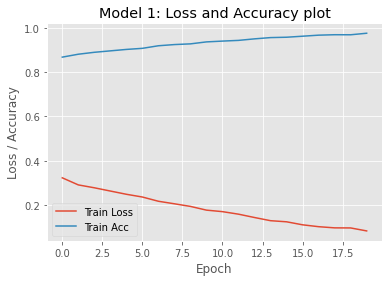

In [ ]:
epochs = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), hist1.history["loss"], label = "Train Loss")
plt.plot(np.arange(0, epochs), hist1.history["accuracy"], label = "Train Acc")
plt.title("Model 1: Loss and Accuracy plot")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc = "lower left")

In [ ]:
# 2nd model

model2 = Sequential()
model2.add(LSTM(60, input_shape=(35,50), return_sequences=True))
model2.add(LSTM(60, dropout = 0.5, return_sequences=True))
model2.add(LSTM(128))
model2.add(Dense(1)) 
model2.add(Activation('sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 35, 60)            26640     
                                                                 
 lstm_5 (LSTM)               (None, 35, 60)            29040     
                                                                 
 lstm_6 (LSTM)               (None, 128)               96768     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 152,577
Trainable params: 152,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist2 = model2.fit(embedding_matrix_train,
                 Y_train,
                 epochs = 20,
                 batch_size=32,
                 shuffle=True)

# 3 minutes
# 2 minutes

Epoch 1/20
285/285 [==============================] - 29s 83ms/step - loss: 0.3224 - accuracy: 0.8684
Epoch 2/20
285/285 [==============================] - 24s 83ms/step - loss: 0.2904 - accuracy: 0.8816
Epoch 3/20
285/285 [==============================] - 24s 83ms/step - loss: 0.2773 - accuracy: 0.8903
Epoch 4/20
285/285 [==============================] - 24s 83ms/step - loss: 0.2626 - accuracy: 0.8968
Epoch 5/20
285/285 [==============================] - 24s 83ms/step - loss: 0.2480 - accuracy: 0.9033
Epoch 6/20
285/285 [==============================] - 24s 83ms/step - loss: 0.2356 - accuracy: 0.9082
Epoch 7/20
285/285 [==============================] - 24s 83ms/step - loss: 0.2164 - accuracy: 0.9199
Epoch 8/20
285/285 [==============================] - 24s 83ms/step - loss: 0.2049 - accuracy: 0.9252
Epoch 9/20
285/285 [==============================] - 24s 83ms/step - loss: 0.1931 - accuracy: 0.9284
Epoch 10/20
285/285 [==============================] - 23s 82ms/step - loss: 0.176

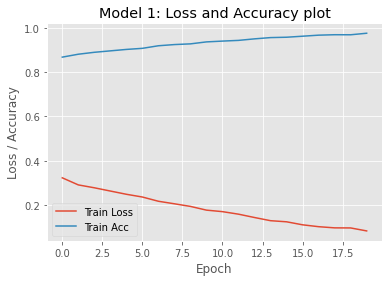

In [ ]:
epochs = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), hist2.history["loss"], label = "Train Loss")
plt.plot(np.arange(0, epochs), hist2.history["accuracy"], label = "Train Acc")
plt.title("Model 2: Loss and Accuracy plot")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc = "lower left")

In [ ]:
#------------------------- PART 7 : Evaluate the models ------------------------

In [ ]:
# Predictions
pred1 = model1.predict(embedding_matrix_test)
pred1 = (model1.predict(embedding_matrix_test) > 0.5).astype("int64") #rounded

pred2 = model2.predict(embedding_matrix_test)
pred2 = (model2.predict(embedding_matrix_test) > 0.5).astype("int64") #rounded

In [ ]:
# Comparison between the prediction and the true values in the test set

# Model 1
print('Model1:')
sum = 0
error = 0
for ix in range(pred1.shape[0]):
  if pred1[ix] == Y_test[ix]: #If the prediction is correct
    sum = sum + 1 #Add one
  else:
    error = error + 1 #Else consider it an error
print("Number of correct tested prediction for the first model:", sum)
print("Correct tested prediction:", 100*round(sum/pred1.shape[0],2), "%")
print("False tested prediction:", 100*round(error/pred1.shape[0],2), "%")

# Model 2
print("\nModel2:")
sum2 = 0
error2 = 0
for ix in range(pred2.shape[0]):
  if pred2[ix] == Y_test[ix]: #If the prediction is correct
    sum2 = sum2 + 1 #Add one
  else:
    error2 = error2 + 1 #Else consider it an error
print("Number of correct tested prediction for the second model:", sum2)
print("Correct tested prediction:", 100*round(sum2/pred2.shape[0],2), "%")
print("False tested prediction:", 100*round(error2/pred2.shape[0],2), "%")

Model1:
Number of correct tested prediction for the first model: 1895
Correct tested prediction: 83.0 %
False tested prediction: 17.0 %

Model2:
Number of correct tested prediction for the second model: 1890
Correct tested prediction: 83.0 %
False tested prediction: 17.0 %


In [ ]:
# Print some well predicted tweets (model 1) related to the disaster
print("Some well predicted tweets (model1) related to the disaster (Test set):\n")
index = X_train.shape[0] #This is the index of the split 
for ix in range(35):
  if pred1[ix] == Y_test[ix] == 1 : #If the prediction is correct and is 1
    print("Tweet n°",ix, end=": ") #Print the number of the line in the test set
    print(data.iloc[index+ix][0]) #Print the original tweet from the data set

# Print some well predicted tweets (model 1) not related to the disaster
print("\n\nSome well predicted tweets (model1) not related to the disaster (Test set):\n")
index = X_train.shape[0] #This is the index of the split 
for ix in range(7):
  if pred1[ix] == Y_test[ix] == 0: #If the prediction is correct and is 0
    print("Tweet n°",ix, end=": ") #Print the number of the line in the test set
    print(data.iloc[index+ix][0]) #Print the original tweet from the data set

Some well predicted tweets (model1) related to the disaster (Test set):

Tweet n° 3: Taal volcano news  live Hundreds thousands urged flee possible eruption intense seismic activity rocks
Tweet n° 24:  quake strikes Puerto Rico amid heavy seismic activity
Tweet n° 27: Strong seismic movement detected home As  detected TZ
Tweet n° 29: HEADLINE  earthquake strikes Puerto Rico killing amid heavy seismic activity Can inte


Some well predicted tweets (model1) not related to the disaster (Test set):

Tweet n° 0: Heard seismic activity going on Brings memories Hawaii big one Hows right now
Tweet n° 1: Blimey His departure seismic
Tweet n° 2: Well wear tan suit Like meant seismic scandal like that
Tweet n° 5: NowPlaying CollegeUndergroundRadio Seismic Anamoly  OMG
Tweet n° 6: We cant address customer data trends acknowledging impact customer data customer ex


In [ ]:
# Print some well predicted tweets (model 2) related to the disaster
print("Some well predicted tweets (model2) related to the disaster (Test set):\n")
index = X_train.shape[0] #This is the index of the split 
for ix in range(32,40):
  if pred2[ix] == Y_test[ix] == 1 : #If the prediction is correct and is 1
    print("Tweet n°",ix, end=": ") #Print the number of the line in the test set
    print(data.iloc[index+ix][0]) #Print the original tweet from the data set

# Print some well predicted tweets (model 1) not related to the disaster
print("\n\nSome well predicted tweets (model2) not related to the disaster (Test set):\n")
index = X_train.shape[0] #This is the index of the split 
for ix in range(7,12):
  if pred2[ix] == Y_test[ix] == 0: #If the prediction is correct and is 0
    print("Tweet n°",ix, end=": ") #Print the number of the line in the test set
    print(data.iloc[index+ix][0]) #Print the original tweet from the data set

Some well predicted tweets (model2) related to the disaster (Test set):

Tweet n° 32: UPDATE JANUARY  PM The intense seismic activity coupled fissuring the
Tweet n° 35: Eruption update pm Lava fountains reached m New fissures cracks observed towns Intens
Tweet n° 36: UPDATE JANUARY  PM The intense seismic activity coupled fissuring t
Tweet n° 39: Strong seismic movement detected home As  detected TZ


Some well predicted tweets (model2) not related to the disaster (Test set):

Tweet n° 7: OGDCL acquires LKMs D seismic data quarter
Tweet n° 8: The intense seismic activity coupled fissuring caldera region likely signifies continuous magma intrus
Tweet n° 9:  keeps walking away startups    Time Energy Goodwill Ho
Tweet n° 10: All stations installed Puerto Rico Im proud work field crew Way
Tweet n° 11: Our issue live Check articles on  Global greening  Sealevel rise human migration  Seismic w


In [ ]:
#------------------------- PART 8 : Plot the results ---------------------------

In [ ]:
#---------------------------------- MODEL 1 ------------------------------------

Confusion matrix for model1 :
Accuracy: 83.33%
Classification Report : 
,              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1738
           1       0.70      0.52      0.59       536

    accuracy                           0.83      2274
   macro avg       0.78      0.72      0.74      2274
weighted avg       0.82      0.83      0.82      2274



[Text(0, 0.5, 'Not Related'), Text(0, 1.5, 'Related')]

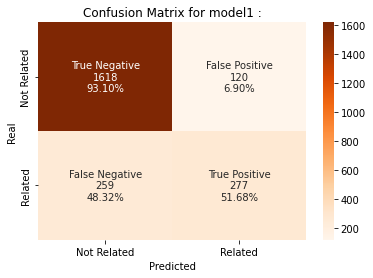

In [ ]:
### Confusion Matrix for model1
Y_pred1 = pred1.copy()
cm1 = confusion_matrix(Y_test, Y_pred1)

print("Confusion matrix for model1 :")
print("Accuracy: {:.2f}%".format(accuracy_score(Y_test, Y_pred1)*100))
print(f"Classification Report : \n,{classification_report(Y_test, Y_pred1)}")

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix(Y_test, Y_pred1).flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                    confusion_matrix(Y_test, Y_pred1, normalize='true').flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, Y_pred1), annot=labels, fmt='', cmap='Oranges', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('Real'); 
ax.set_title('Confusion Matrix for model1 :'); 
ax.xaxis.set_ticklabels(['Not Related', 'Related']); ax.yaxis.set_ticklabels(['Not Related', 'Related'])

In [ ]:
# Analyse for model
TN1 = cm1[0][0]
FP1 = cm1[0][1]
FN1 = cm1[1][0]
TP1 = cm1[1][1]
total1 = TN1+FP1+FN1+TP1

print(f'Correctly classified: {np.round((TP1+TN1)/total1*100)}%')
print(f'Tweets predicted "related" that are truly "related" to the disaster: {np.round(TP1/(TP1+FN1)*100)}%') #Sensitivity or recall :  This metric allows to detect how many truly related we were'nt able to predict. It is the ability to the model to correclty classify a tweet as "related".
print(f'Tweets predicted "not related" that are truly "not related" to the disaster: {np.round(TN1/(TN1+FP1)*100)}%') #Specifity or true negative rate.  A good model must be both sensitive and specific.
print(f'Tweets truly "related" to the disaster that were correctly predicted: {np.round(TP1/(TP1+FP1)*100)}%') #Precision : This metric allows to detect errors or prediction, meaning how well we recognize "related" tweets and differenciate it. A high false negative rate is not good.
print(f'Tweets truly "not related" that were correctly predicted: {np.round(TN1/(TN1+FN1)*100)}%') #Negative predicted value: This metric gives us a visibility on how many of "not related" predictions are true negative.

Correctly classified: 83.0%
Tweets predicted "related" that are truly "related" to the disaster: 52.0%
Tweets predicted "not related" that are truly "not related" to the disaster: 93.0%
Tweets truly "related" to the disaster that were correclty predicted: 70.0%
Tweets truly "not related" that were correctly predicted: 86.0%


In [ ]:
#---------------------------------- MODEL 2 ------------------------------------

Confusion matrix for model2 :
Accuracy: 83.11%
Classification Report : 
,              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1738
           1       0.66      0.59      0.62       536

    accuracy                           0.83      2274
   macro avg       0.77      0.75      0.76      2274
weighted avg       0.83      0.83      0.83      2274



[Text(0, 0.5, 'Not Related'), Text(0, 1.5, 'Related')]

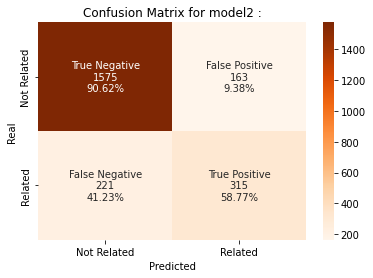

In [ ]:
### Confusion Matrix for model2
Y_pred2 = pred2.copy()
cm2 = confusion_matrix(Y_test, Y_pred2)

print("Confusion matrix for model2 :")
print("Accuracy: {:.2f}%".format(accuracy_score(Y_test, Y_pred2)*100))
print(f"Classification Report : \n,{classification_report(Y_test, Y_pred2)}")

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix(Y_test, Y_pred2).flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                    confusion_matrix(Y_test, Y_pred2, normalize='true').flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, Y_pred2), annot=labels, fmt='', cmap='Oranges', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('Real'); 
ax.set_title('Confusion Matrix for model2 :'); 
ax.xaxis.set_ticklabels(['Not Related', 'Related']); ax.yaxis.set_ticklabels(['Not Related', 'Related'])

In [ ]:
# Analyse for model2
TN2 = cm2[0][0]
FP2 = cm2[0][1]
FN2 = cm2[1][0]
TP2 = cm2[1][1]
total2 = TN2+FP2+FN2+TP2

print(f'Correctly classified: {np.round((TP2+TN2)/total2*100)}%')
print(f'Tweets predicted "related" that are truly "related" to the disaster: {np.round(TP2/(TP2+FN2)*100)}%') #Sensitivity or recall :  This metric allows to detect how many truly related we were'nt able to predict. It is the ability to the model to correclty classify a tweet as "related".
print(f'Tweets predicted "not related" that are truly "not related" to the disaster: {np.round(TN2/(TN2+FP2)*100)}%') #Specifity or true negative rate.  A good model must be both sensitive and specific.
print(f'Tweets truly "related" to the disaster that were correctly predicted: {np.round(TP2/(TP2+FP2)*100)}%') #Precision : This metric allows to detect errors or prediction, meaning how well we recognize "related" tweets and differenciate it. A high false negative rate is not good.
print(f'Tweets truly "not related" that were correctly predicted: {np.round(TN2/(TN2+FN2)*100)}%') #Negative predicted value: This metric gives us a visibility on how many of "not related" predictions are true negative.

Correctly classified: 83.0%
Tweets predicted "related" that are truly "related" to the disaster: 59.0%
Tweets predicted "not related" that are truly "not related" to the disaster: 91.0%
Tweets truly "related" to the disaster that were correclty predicted: 66.0%
Tweets truly "not related" that were correctly predicted: 88.0%
